In [67]:
# Sentiment algorithm 1. Sequence of lemmas as single feature input and binary sentiment classification of sentence as output

# Model is saved in saved_models/model_name/model_variant.h5
# Run history is saved in logged_models/model_name sorted by model_variants and run-datetime
# Runs can be viewed using tensorboard: tensorboard --logdir=PATH --port=6006
# Example given: tensorboard --logdir=C:\BAC\Ezra\sentiment\models\logged_models\sent_algo_1 --port=6006
model_name = 'sent_algo_1'
model_variant = 'w_mask'

training_size = 30000
test_size = 10000

In [68]:
# SETUP IMPORTS
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import time
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import os
import time
import tensorflow as tf
from keras import callbacks

%reload_ext autoreload
%autoreload 2
from helpers.sentiment_functions import gender_seq_to_single
from helpers.sentiment_functions import equal_genders
from helpers.sentiment_functions import encode_feature
from helpers.sentiment_functions import plot_sentence_lengths
from helpers.sentiment_functions import plot_confusion_matrix
from helpers.sentiment_functions import get_metrics
from helpers.sentiment_functions import xai_binary

pd.set_option('display.max_columns', 10, 'display.width', 15, 'display.max_colwidth', 15, 'display.max_rows',100)

In [69]:
# LOAD DATASET
df = pd.read_json('../datasets/sentiment_corpus.json')
print("Corpus sample size is:", len(df))

print(training_size, "samples are taken from the head for training")
print(test_size, "samples are taken from the tail for test")

# We take from the head for training data and tail for test data
# This is done since the last 25% of the corpus is not fitted on the polarity dict, thereby preventing overfitting
train_data = df.head(training_size)
test_data = df.tail(test_size)

train_data

Corpus sample size is: 4970467
30000 samples are taken from the head for training
10000 samples are taken from the tail for test


,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1,organizations,organization,NOUN,-0.223025,F
1,1,decided,decide,VERB,-0.039008,F
2,1,drop,drop,VERB,-0.058436,F
3,1,women,woman,NOUN,0.272143,F
4,1,accused,accuse,VERB,0.006282,F
...,...,...,...,...,...,...
29995,3967,reaction,reaction,NOUN,0.006468,F
29996,3968,insane,insane,ADJ,0.000000,F
29997,3968,cyberbullying,cyberbullying,NOUN,0.000000,F
29998,3968,said,say,VERB,-0.564779,F


In [70]:
# GROUP-BY SENTENCE NUMBER 
train_data = train_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))
test_data = test_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))

train_data['Gender'] = gender_seq_to_single(train_data['Gender'])
test_data['Gender'] = gender_seq_to_single(test_data['Gender'])
train_data

C:\Users\hanse\AppData\Local\Temp/ipykernel_28376/3370681660.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train_data = train_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))
C:\Users\hanse\AppData\Local\Temp/ipykernel_28376/3370681660.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test_data = test_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))


,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1,[organizati...,[organizati...,"[NOUN, VERB...",[-0.2230248...,F
1,2,"[Women, pre...","[woman, pre...","[NOUN, ADV,...",[0.27214283...,F
2,3,"[response, ...","[response, ...","[NOUN, NOUN...",[-0.0280537...,F
3,4,"[aware, all...","[aware, all...","[ADJ, NOUN,...",[-0.0157154...,F
4,5,"[point, Vis...","[point, Vis...","[NOUN, PROP...",[-0.2287299...,F
...,...,...,...,...,...,...
3320,3965,"[People, di...","[People, di...","[NOUN, AUX,...",[-0.0271288...,F
3321,3966,"[article, i...","[article, i...","[NOUN, VERB...",[-0.0543934...,F
3322,3967,"[said, unpr...","[say, unpre...","[VERB, ADJ,...",[-0.5647787...,F
3323,3968,"[insane, cy...","[insane, cy...","[ADJ, NOUN,...","[0.0, 0.0, ...",F


In [71]:
# SHUFFLE TRAINING AND TEST DATA
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)
train_data

,Sentence #,Word,Lemma,POS,Polarity,Gender
0,3792,"[began, Mas...","[begin, Mas...","[VERB, PROP...",[-0.0937346...,M
1,1060,"[New, Yorke...","[New, Yorke...","[PROPN, PRO...",[-0.0957173...,F
2,978,"[Cornell, U...","[Cornell, U...","[PROPN, PRO...","[0.0, -0.10...",F
3,3574,"[song, feat...","[song, feat...","[NOUN, VERB...",[0.01846751...,F
4,3104,"[talk, end,...","[talk, end,...","[VERB, VERB...",[-0.0543269...,F
...,...,...,...,...,...,...
3320,1982,"[U, regulat...","[u, regulat...","[NOUN, NOUN...","[0.0, -0.02...",M
3321,2917,"[heavily, L...","[heavily, l...","[ADV, ADJ, ...","[0.0, 0.0, ...",M
3322,554,"[President,...","[President,...","[PROPN, VER...",[-0.0685674...,M
3323,2267,"[Raisman, l...","[Raisman, l...","[PROPN, VER...","[0.0, -0.24...",F


<AxesSubplot:>

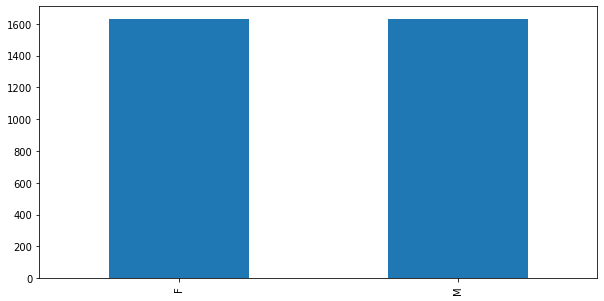

In [72]:
# EQUAL GENDER SAMPLES TO PREVENT BIAS
train_data = equal_genders(train_data)
test_data = equal_genders(test_data)

train_data["Gender"].value_counts().plot(kind="bar", figsize=(10,5))

No handles with labels found to put in legend.


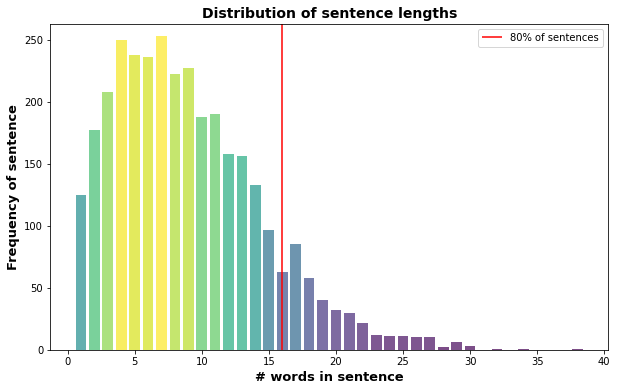

Decision boundary / 80 pct of sentence lengths is: 16


In [73]:
# VISUALIZE SENTENCE LENGTHS AND DECISION BOUNDARY
decision_boundary = plot_sentence_lengths(train_data)
print("Decision boundary / 80 pct of sentence lengths is:", decision_boundary)

In [74]:
# ENCODE FEATURES TO INTEGERS, EQUAL LENGTHS AND PAD
# Inspired by: https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
train_data['Lemma_enc'], test_data['Lemma_enc'], vocab_size = encode_feature(train_data['Lemma'], test_data['Lemma'])

trunc_type = 'post'
padding_type = 'post'
max_len = decision_boundary

X_train = pad_sequences(train_data['Lemma_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)
X_test = pad_sequences(test_data['Lemma_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)

In [75]:
# ONE-HOT TARGET (GENDER)
le = LabelEncoder()
le.classes_ = ['M', 'F']

y_train = le.transform(train_data['Gender'])
y_test = le.transform(test_data['Gender'])

y_train = to_categorical(y_train)

print('[M] =', le.transform(['M']), '=', to_categorical(le.transform(['M']),2))
print('[F] =', le.transform(['F']), '=', to_categorical(le.transform(['F']),2))

[M] = [0] = [[1. 0.]]
[F] = [1] = [[0. 1.]]


In [76]:
# DEFINING KERAS CALLBACKS

# Borrowed from: https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

root_logdir = os.path.join(os.curdir, "./logged_models/" + model_name + '/' + model_variant)
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_log_dir = get_run_logdir()
file_writer = tf.summary.create_file_writer(run_log_dir + "/metrics")
file_writer.set_as_default()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

my_callbacks = [earlystopping, tensorboard_cb]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 128)           688384    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 16, 256)           263168    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 1,116,162
Trainable params: 1,116,162
Non-trainable params: 0
_________________________________________________________________


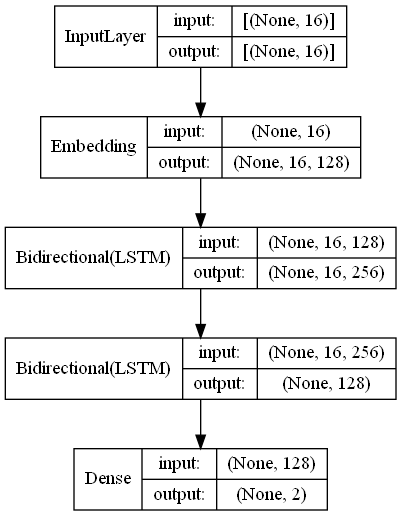

In [77]:
# DEFINING AND PLOTTING MODEL
embedding_dim = 128

model = tf.keras.Sequential([
    layers.Embedding(vocab_size+1, embedding_dim, input_length=max_len, mask_zero=True),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    layers.Bidirectional(layers.LSTM(64, return_sequences=False, dropout=0.1, recurrent_dropout=0.1)),
    layers.Dense(2, activation="softmax")
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # cross entropy loss chapter 4 HOML - categorial crossentropy because to_categorial 

model.summary()

plot_model(model, show_shapes=True, show_layer_names=False)

In [78]:
# FITTING MODEL

history = model.fit(X_train, y_train, epochs=20, callbacks=my_callbacks, validation_split=0.2)

Epoch 1/20
82/82 [==============================] - 54s 113ms/step - loss: 0.5388 - accuracy: 0.6901 - val_loss: 0.4200 - val_accuracy: 0.8144
Epoch 2/20
82/82 [==============================] - 6s 72ms/step - loss: 0.2308 - accuracy: 0.9090 - val_loss: 0.4425 - val_accuracy: 0.7975
Epoch 3/20
82/82 [==============================] - 6s 68ms/step - loss: 0.1202 - accuracy: 0.9455 - val_loss: 0.5346 - val_accuracy: 0.7960
Epoch 4/20
82/82 [==============================] - 5s 66ms/step - loss: 0.0739 - accuracy: 0.9681 - val_loss: 0.6942 - val_accuracy: 0.7960
Epoch 5/20
82/82 [==============================] - 5s 65ms/step - loss: 0.0554 - accuracy: 0.9793 - val_loss: 0.6336 - val_accuracy: 0.7853
Epoch 6/20
82/82 [==============================] - 5s 66ms/step - loss: 0.0417 - accuracy: 0.9850 - val_loss: 0.7421 - val_accuracy: 0.7791


red is training, blue is validation


<Figure size 432x288 with 0 Axes>

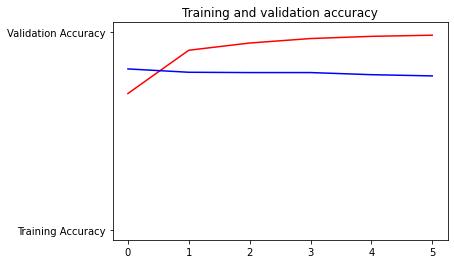

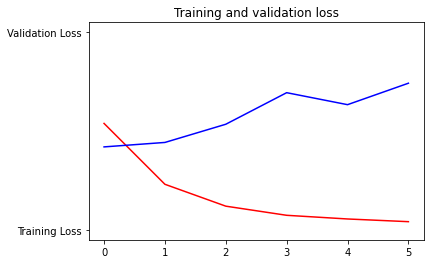

<Figure size 432x288 with 0 Axes>

In [79]:
# PLOTTING HISTORY OF FITTING
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')

print("red is training, blue is validation")
plt.figure()

In [80]:
# SAVING MODEL
model.save('saved_models/' + model_name + '/' + model_variant + '.h5')

In [81]:
# PREDICT TEST DATA
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
y_pred = y_pred.flatten()
y_pred

array([1, 1, 1, ..., 1, 0, 0], dtype=int64)

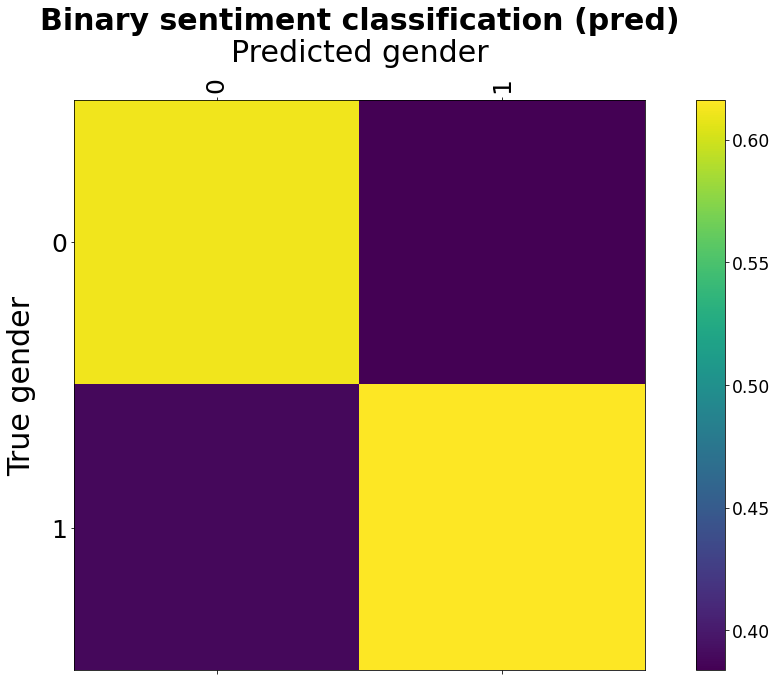

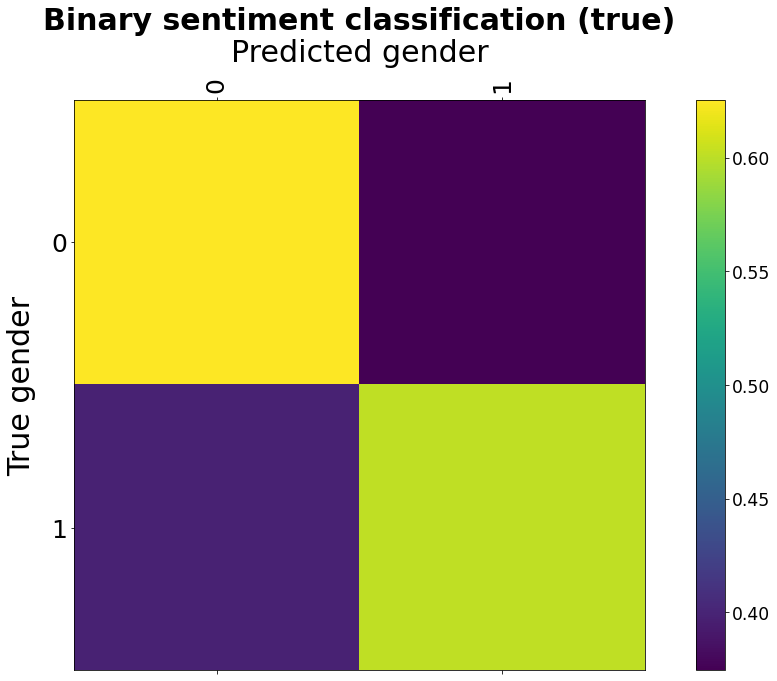

In [82]:
# PLOTTING CONFUSION MATRIX
plot_confusion_matrix(np.array(y_test).flatten(), y_pred, 'Binary sentiment classification', 'Predicted gender', 'True gender')

In [83]:
# PRINTING METRICS
sentiment_vocab = ['M', 'F']
get_metrics(y_test, y_pred, sentiment_vocab, 'Gender')

C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
c:\BAC\Ezra\sentiment\models\helpers\sentiment_functions.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)


,Gender,precision,recall,f1-score,support
0,M,0.61,0.63,0.62,502.0
1,F,0.62,0.60,0.61,502.0


In [84]:
# USE XAI ON PREDICTIONS
xai_binary(y_pred[:100], test_data, 2)


---------------------------------------------------------------------------------------
The sentence: "I'm good with either.".

Was predicted to be feminine (1).

Most feminine words in sentence are:

'good' with a polarity of -0.27

---------------------------------------------------------------------------------------
The sentence: ""We were very much left to ourselves, and we overcame it," Tsang said.".

Was predicted to be feminine (1).

Most feminine words in sentence are:

'overcame' with a polarity of 0.0
'left' with a polarity of -0.14

---------------------------------------------------------------------------------------
The sentence: "(Editing by Chistopher Wilson)  ".

Was predicted to be feminine (1).

Most feminine words in sentence are:

'Editing' with a polarity of -0.02

---------------------------------------------------------------------------------------
The sentence: ""This has got to have effects on influence, perceptions of power in the world that are going to b